## Version 3
Okay we need to refactor this whole thing (version 02), to be more maintainable, and prepared for putting into production.
Also the devops guys say they are now enforcing pull requests with code quality checking so our code needs to be less "smelly" or the pull request won't be accepted. Installing Ruff can help with that apparently.  
Also DONT COMMIT DIRECTLY TO MAIN!

Add autoreload since we are now modifying scripts in other folders.

In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Getting the data again.

In [50]:

import sys
import os

sys.path.append(os.path.abspath(".."))

from ARISA_DSML.preproc import get_raw_data
from ARISA_DSML.config import RAW_DATA_DIR, target, categorical

In [51]:

import os
from pathlib import Path
container_check = os.getenv("iscontainer")
if container_check=="y":
    config_dir = Path("/home/vscode/.config/kaggle")
    config_dir.mkdir(parents=True, exist_ok=True)

    with open(config_dir / "kaggle.json", "w") as dst:
        with open("../kaggle.json", "r") as src:
            dst.write(src.read())

In [52]:
get_raw_data()
!dir "{RAW_DATA_DIR}"

2025-06-19 22:51:02.565 | INFO     | ARISA_DSML.preproc:get_raw_data:19 - RAW_DATA_DIR is: /home/lkwasniewski/repos/00001_Studia/MLOPSGradedFinal/data/raw


Dataset URL: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
bots_vs_users.csv  diabetes_new_test.csv  test.csv
diabetes.csv	   diabetes_test.csv


Load preproc from preproc.py and run on train data:

In [53]:
from ARISA_DSML.preproc import preprocess_df

train_path = preprocess_df(RAW_DATA_DIR / "diabetes.csv")

/home/lkwasniewski/repos/00001_Studia/MLOPSGradedFinal/ARISA_DSML/preproc.py:33: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/home/lkwasniewski/repos/00001_Studia/MLOPSGradedFinal/ARISA_DSML/preproc.py:33: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/home/lkwasniewski/repos/00001_Studia/MLOPSGradedFinal/ARISA_DSML/preproc.py:33: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option

In [54]:
train_path

PosixPath('/home/lkwasniewski/repos/00001_Studia/MLOPSGradedFinal/data/processed/diabetes.csv')

In [55]:
import pandas as pd
df_train = pd.read_csv(train_path)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


Split into X and y, get categorical indices:

In [56]:
y_train = df_train.pop(target)
X_train = df_train

categorical_indices = []
categorical_indices

[]

And run the hyperparameter optimization (if ):

In [57]:
from ARISA_DSML.train import run_hyperopt

best_params_path = run_hyperopt(X_train, y_train, categorical_indices)

2025-06-19 22:51:03.772 | INFO     | ARISA_DSML.train:run_hyperopt:82 - Best Parameters: {'depth': 3, 'learning_rate': 0.2847856453953337, 'iterations': 101, 'l2_leaf_reg': 0.08064725446361332, 'bagging_temperature': 0.4441828029429478, 'random_strength': 9.931197047043607}


Do cross validation again:

In [58]:
import joblib
from ARISA_DSML.train import train_cv
params = joblib.load(best_params_path)
display(params)
n_folds = 5
cv_output_path = train_cv(X_train, y_train, categorical_indices, params, n=n_folds)

{'depth': 3,
 'learning_rate': 0.2847856453953337,
 'iterations': 101,
 'l2_leaf_reg': 0.08064725446361332,
 'bagging_temperature': 0.4441828029429478,
 'random_strength': 9.931197047043607}

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 3.21ms	remaining: 321ms
1:	learn: 0.5061728	test: 0.5714286	best: 0.5714286 (1)	total: 5.43ms	remaining: 269ms
2:	learn: 0.4728435	test: 0.5185185	best: 0.5714286 (1)	total: 7.67ms	remaining: 251ms
3:	learn: 0.4300341	test: 0.5063291	best: 0.5714286 (1)	total: 9.94ms	remaining: 241ms
4:	learn: 0.4774194	test: 0.5128205	best: 0.5714286 (1)	total: 12.4ms	remaining: 237ms
5:	learn: 0.4922118	test: 0.5250000	best: 0.5714286 (1)	total: 14.3ms	remaining: 226ms
6:	learn: 0.5498489	test: 0.5679012	best: 0.5714286 (1)	total: 25.8ms	remaining: 346ms
7:	learn: 0.5481928	test: 0.5679012	best: 0.5714286 (1)	total: 29.2ms	remaining: 340ms
8:	learn: 0.5552239	test: 0.5609756	best: 0.5714286 (1)	total: 31.2ms	remaining: 319ms
9:	learn: 0.5568862	test: 0.5609756	best: 0.5714286 (1)	total: 35.6ms	remaining: 324ms
10:	learn: 0.5780347	test: 0.5882353	best: 0.5882353 (10)	total: 38ms	remaining: 311ms
11:	learn: 0.5786517

And get the performance plots:

In [59]:
from ARISA_DSML.train import plot_error_scatter
cv_results = pd.read_csv(cv_output_path)
plot_error_scatter(
    df_plot=cv_results,
    name="Mean F1 Score",
    title="Cross-Validation (N=5) Mean F1 score with Error Bands",
    xtitle="Training Steps",
    ytitle="Performance Score",
    yaxis_range=[0.5, 1],
)

In [60]:
plot_error_scatter(
    df_plot=cv_results,
    x="iterations",
    y="test-Logloss-mean",
    err="test-Logloss-std",
    name="Mean logloss",
    title="Cross-Validation (N=5) Mean Logloss with Error Bands",
    xtitle="Training Steps",
    ytitle="Logloss",
)


Fit model on full dataset:

In [61]:
from ARISA_DSML.train import train

model_path, model_params_path = train(X_train, y_train, categorical_indices, params, cv_results=cv_results)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2130178	total: 654us	remaining: 65.4ms
50:	learn: 0.7410359	total: 16.6ms	remaining: 16.2ms
100:	learn: 0.8441815	total: 34.4ms	remaining: 0us


/home/lkwasniewski/repos/00001_Studia/.venv-mlops/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

Registered model 'diabetes-binary-class' already exists. Creating a new version of this model...
Created version '7' of model 'diabetes-binary-class'.
/home/lkwasniewski/repos/00001_Studia/MLOPSGradedFinal/ARISA_DSML/train.p

And now for the test set, because of our refactor, we don't need to copy paste anymore:

In [62]:
dataset_test_path = RAW_DATA_DIR / "test.csv"
preprocced_test_path = preprocess_df(dataset_test_path)
df_test = pd.read_csv(preprocced_test_path)
df_test["Age"].unique()

df_test.head()

/home/lkwasniewski/repos/00001_Studia/MLOPSGradedFinal/ARISA_DSML/preproc.py:33: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/home/lkwasniewski/repos/00001_Studia/MLOPSGradedFinal/ARISA_DSML/preproc.py:33: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/home/lkwasniewski/repos/00001_Studia/MLOPSGradedFinal/ARISA_DSML/preproc.py:33: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72.0,35.0,131.0,33.6,0.627,50,1
1,1,85,66.0,29.0,131.0,26.6,0.351,31,0
2,8,183,64.0,33.5,131.0,23.3,0.672,32,1
3,1,89,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137,40.0,35.0,168.0,43.1,2.288,33,1


In [63]:
df_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33


Get predictions and shap plot:

{'depth': 3,
 'learning_rate': 0.2847856453953337,
 'iterations': 101,
 'l2_leaf_reg': 0.08064725446361332,
 'bagging_temperature': 0.4441828029429478,
 'random_strength': 9.931197047043607,
 'eval_metric': 'F1',
 'loss_function': 'Logloss',
 'ignored_features': [],
 'feature_columns': ['Pregnancies',
  'Glucose',
  'BloodPressure',
  'SkinThickness',
  'Insulin',
  'BMI',
  'DiabetesPedigreeFunction',
  'Age']}

KeyError: "['predicted_probability'] not in index"

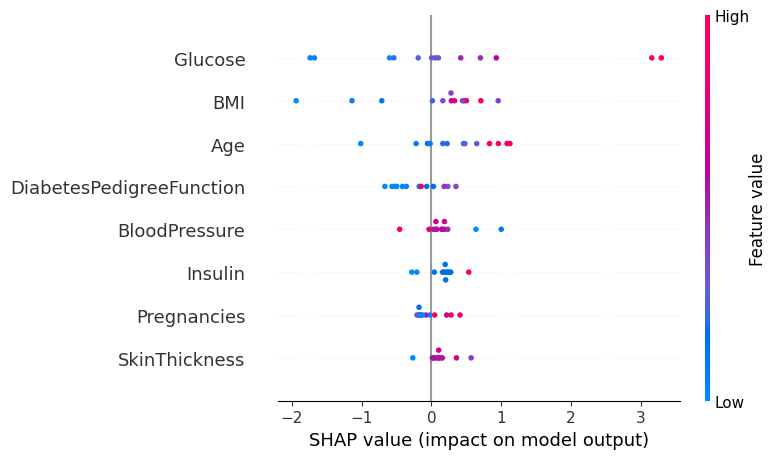

In [65]:
from ARISA_DSML.predict import predict
from catboost import CatBoostClassifier

params = joblib.load(model_params_path)
display(params)
from_file = CatBoostClassifier()
model = from_file.load_model(str(model_path))
preds_path = predict(model, df_test, params)


And that's it for the refactor.  
As can be seen from the notebook, the goal is to have as little code as possible in the actual notebook cells,  
which makes it much easier to maintain and, as we will see shortly, productionalize.